In [1]:
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox, LTTextLine
import re, os, shutil
from pprint import pprint
import pandas as pd


In [2]:
adress_folder = r'C:\Users\hobx2\Anaconda3\My\PDF\january'  # Папка с актами

# сюда запишем все нужные данные с листов pdf
data_acts = {
    'num_act' : [],
    'data_act' : [],
    'customer_name' : [],
    'customer_inn' : [],
    'customer_adress' : [],
    'payment_basis' : [],
    'servis_name' : [],
    'servis_quant' : [],
    'servis_price' : [],
    'servis_sum' : [],
    'patterns' : {
        'pattern_num_act' : r'Акт № (.+?) от',
        'pattern_data_act' : r'от (\d{1,2} \w+ \d{4} г.)',
        'pattern_customer_name' : r'Заказчик: (.+?), ИНН',
        'pattern_customer_inn' : r'Заказчик.+?(\d{10})',
        'pattern_customer_adress' : r'Заказчик.+\d{10}.+(\d{6}.+?) Основание',
        'pattern_payment_basis' : r'Основание: (.+от.+?) №.+?Товары',
        'pattern_servis_name' : r'\(работы, услуги\) (.+?) Кол-во',
        'pattern_servis_quant' : r'(\d+ шт)',
        'pattern_servis_price' : r'шт (\d+,\d{2})',
        'pattern_servis_sum' : r'Итого:.+?(\d+,\d{2})'
        
    },
    'cnt' : []
}


In [3]:
def pdf_to_text(file : 'pdf') -> 'temp.txt':
    '''Считает из pdf текст и сохранит в temp.txt'''
    fp = open(file, 'rb')
    parser = PDFParser(fp)
    doc = PDFDocument()
    parser.set_document(doc)
    doc.set_parser(parser)
    doc.initialize('')
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.
    fin = open('temp.txt', 'w') # очистка temp.txt
    fin.close()
    fin = open('temp.txt', 'a', encoding = 'utf8')
    temp_text = ''
    for page in doc.get_pages():
        interpreter.process_page(page)
        layout = device.get_result()
        for lt_obj in layout:
            if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                fin.write(lt_obj.get_text())

    fp.close()
    fin.close()
    data_acts['cnt'].append(file[file.rfind('/') + 1:])
     

In [4]:
def add_data() -> None:
    '''Считает temp.txt и добавит данные в словарь data_acts'''
    with open('temp.txt', 'r', encoding = 'utf8') as fin:
        temp_text = fin.read().replace('\n', ' ')
    for key, pattern in data_acts['patterns'].items():
        data_acts[key[8:]].append(re.search(pattern, temp_text).group(1))


In [5]:
os.chdir(adress_folder)
try:
    os.mkdir(adress_folder +'/acts')
except OSError:
    None
cnt = 0
for adress, dires, files in os.walk('.'):
    for i in files:
        if i[:3] == 'Aкт':
            cnt += 1
            shutil.copy(adress_folder + adress[1:] + '/' + i, adress_folder +'/acts/' + str(cnt) + '.pdf')
            pdf_to_text(adress_folder +'/acts/' + str(cnt) + '.pdf')
            add_data()

pd.DataFrame.from_dict({key : value for key, value in data_acts.items() if key not in ('patterns', 'cnt')}).to_excel("output.xlsx") 


In [6]:
data = pd.DataFrame.from_dict({key : value for key, value in data_acts.items() if key not in ('patterns', 'cnt')})

In [10]:
data['servis_price'] = data['servis_price'].apply(lambda x: float(x.replace(',', '.')))

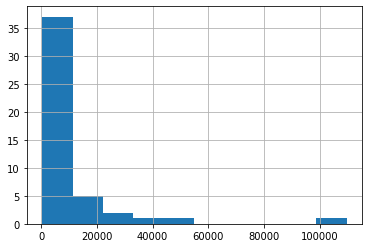

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
data['servis_price'].hist()